# Project v0.5

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report
import datetime
import os

In [2]:
# clean up tendorboard old instances to avoide Tensorboard Error: No dashboards are active for current data set
# sauce https://stackoverflow.com/a/60819054

! powershell "echo 'checking for existing tensorboard processes'"
! powershell "ps | Where-Object {$_.ProcessName -eq 'tensorboard'}"

! powershell "ps | Where-Object {$_.ProcessName -eq 'tensorboard'}| %{kill $_}"

! powershell "echo 'cleaning tensorboard temp dir'"
! powershell "rm $env:TEMP\.tensorboard-info\*"

! powershell "ps | Where-Object {$_.ProcessName -eq 'tensorboard'}"

checking for existing tensorboard processes

Handles  NPM(K)    PM(K)      WS(K)     CPU(s)     Id  SI ProcessName                                                  
-------  ------    -----      -----     ------     --  -- -----------                                                  
     59       5      744       3652       0.00   3144   7 tensorboard                                                  
     59       5      748       3656       0.02  21276   7 tensorboard                                                  


cleaning tensorboard temp dir


In [3]:
print(tf.__version__)

# load tensorboard
%reload_ext tensorboard
%tensorboard --logdir="logs" --host localhost

2.8.0


In [23]:
def make_directories():
    d = datetime.datetime.today()
    timestamp = d.strftime('%Y%m%d_%H%M%S')
    # folder to store the tensorboard logs
    tensorlog_folder = os.path.join(os.path.curdir, 'logs', timestamp)
    # folder to store the trained models
    checkpoint_folder = os.path.join(os.path.curdir, 'models', timestamp)

    os.mkdir(tensorlog_folder)
    os.mkdir(checkpoint_folder)

    print(checkpoint_folder)
    print(tensorlog_folder)
    return checkpoint_folder, tensorlog_folder

# get the required directories
check_dir, tboard_dir = make_directories()

# define the callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoints = keras.callbacks.ModelCheckpoint(
    filepath=check_dir,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

tensorboard = keras.callbacks.TensorBoard(
    log_dir=tboard_dir
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

.\models\20220415_070056
.\logs\20220415_070056


## Parameters

In [39]:
# Define some parameters:

SEED = 0

batch_size = 16
img_height = 256
img_width = 256
class_weight = {0: 1, 1: 0.1}
epochs = 8

### Data path

In [40]:
import pathlib
data_dir = pathlib.Path("./data")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

822


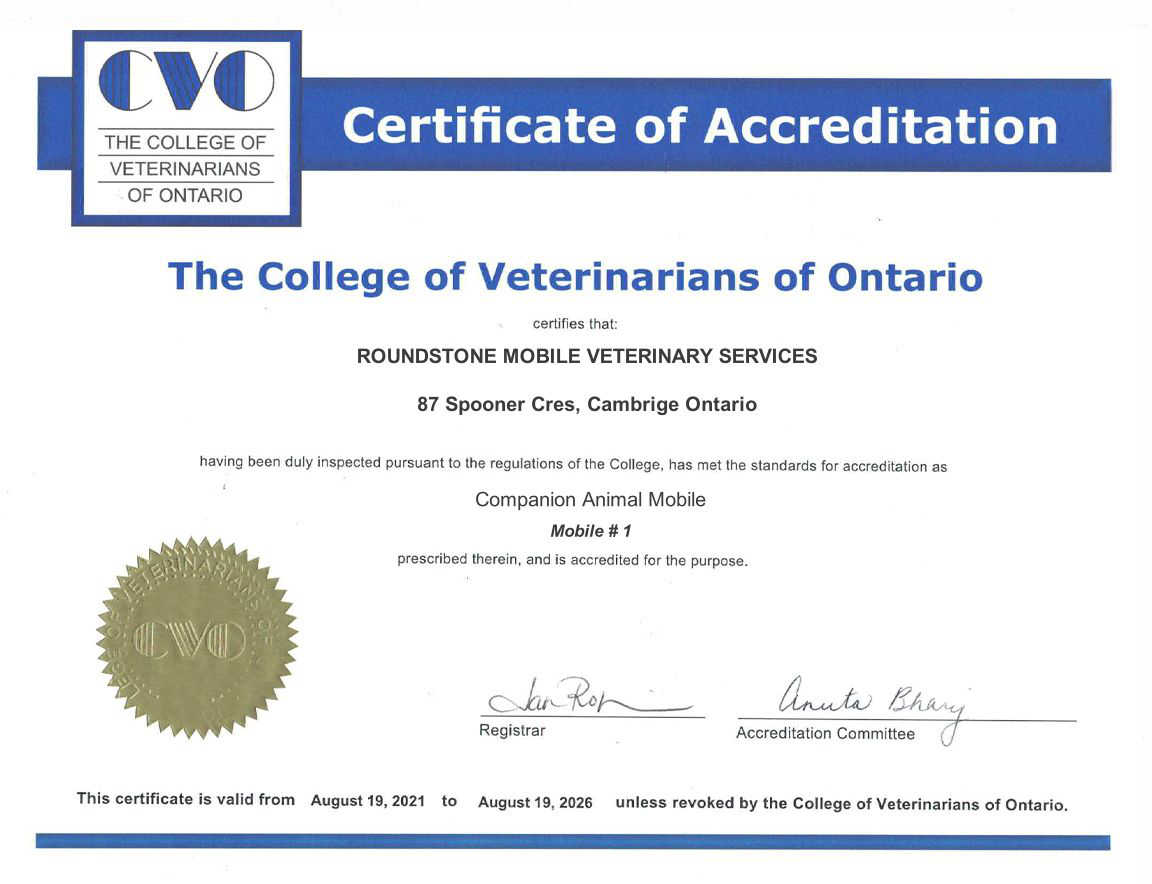

In [41]:
canada_ontario_cvo_imgs = list(data_dir.glob('canada_ontario_cvo/*'))
PIL.Image.open(str(canada_ontario_cvo_imgs[0]))

## Load data using a Keras utility

### Create a dataset

In [42]:
# training/validation split

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 822 files belonging to 2 classes.
Using 658 files for training.
Found 822 files belonging to 2 classes.
Using 164 files for validation.


In [43]:
# classes check

class_names = train_ds.class_names
print(class_names)

['canada_ontario_cvo', 'none']


### Data visualization

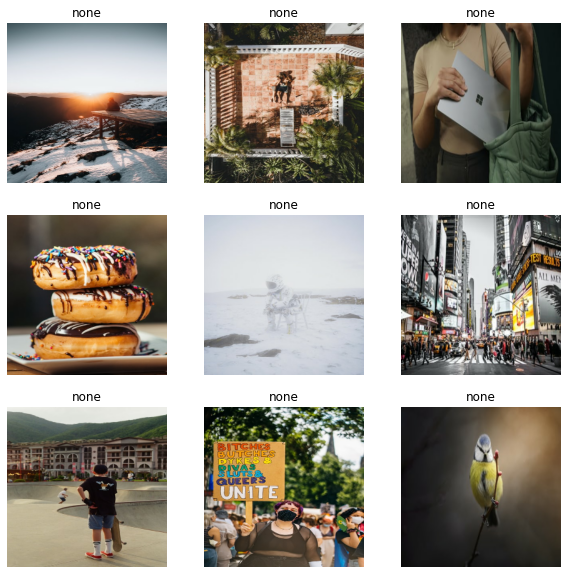

In [44]:
# plot first images from training set

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [45]:
# training batches info

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 256, 256, 3)
(16,)


### Dataset config for performance

In [46]:
# Cache images to improve performance

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data Preprocessing

In [47]:
# resizing and rescaling layers

resize_and_rescale = Sequential([
  layers.Resizing(img_height, img_width, input_shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255)
])

### Data Augmentation

In [48]:
# data augmentation layers

data_augmentation = Sequential(
  [
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
  ]
)

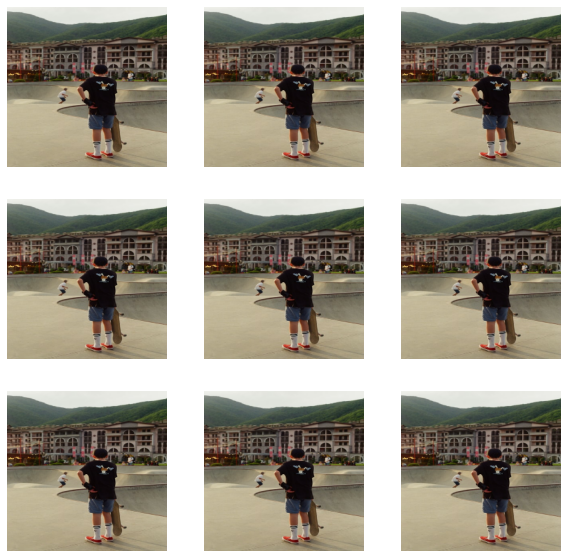

In [49]:
# augmentation example visualization

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Model training

In [50]:
# Sequential model of three convolution blocks  with a max pooling layer

num_classes = len(class_names)

model = Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [51]:
# config to view training and validation accuracy for each training epoch

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [52]:
# model summary

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_7 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [53]:
# training

history = model.fit(
  train_ds,
  class_weight=class_weight,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[reduce_lr, early_stop, checkpoints, tensorboard]
)

Epoch 1/8
42/42 [==============================] - 20s 446ms/step - loss: 0.2036 - accuracy: 0.8435 - val_loss: 0.2053 - val_accuracy: 0.8841 - lr: 0.0010
Epoch 2/8
42/42 [==============================] - 16s 391ms/step - loss: 0.1141 - accuracy: 0.9422 - val_loss: 0.2196 - val_accuracy: 0.9085 - lr: 0.0010
Epoch 3/8
42/42 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9422
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
42/42 [==============================] - 17s 407ms/step - loss: 0.0506 - accuracy: 0.9422 - val_loss: 0.6045 - val_accuracy: 0.6280 - lr: 0.0010
Epoch 4/8
42/42 [==============================] - 19s 455ms/step - loss: 0.0364 - accuracy: 0.8116 - val_loss: 0.1609 - val_accuracy: 0.9512 - lr: 1.0000e-04
Epoch 5/8
42/42 [==============================] - 20s 466ms/step - loss: 0.0127 - accuracy: 0.9894 - val_loss: 0.0315 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/8
42/42 [==============================] - 19s 46

### Visualize training results

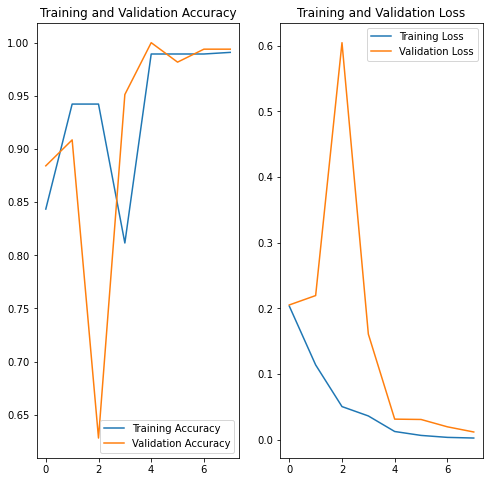

In [54]:
# Create plots of loss and accuracy on the training and validation sets:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# let's try and predict on a none image

This image most likely belongs to none with a 100.00 percent confidence.


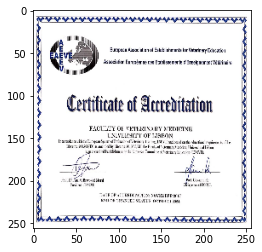

In [55]:
img_path = "./test_data/none_test_2.jpg"

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# let's try and predict on a canada_ontario_cvo image

This image most likely belongs to canada_ontario_cvo with a 86.53 percent confidence.


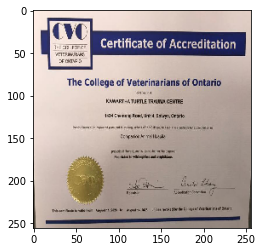

In [56]:
img_path = "./test_data/canada_ontario_cvo_test_2.jpg"

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# OCR. This part was copied from Abir's private repo

In [ ]:
# for this to work you need to install Tesseract and uncomment
# or just check app.js file for implmentation with tesseract.js

# from PIL import Image
# import pytesseract
# import numpy as np

# filename = 'canada_ontario_cvo_1_1.jpg' 
# img1 = np.array(Image.open(filename))
# pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe' #Directory where Tesseract is installed
# text = pytesseract.image_to_string(img1)
# if not 'certifies that' in text :
#     text = text.replace("Ontario","Ontario certifies that" )
    
# #print(text)
# hhh =text.split("that",1)[1].split("having",1)[0]
# ddd = hhh.splitlines()
# while '' in ddd:
#     ddd.remove('')
# for tx in ddd :
           
#     if len(tx)<2:
#         ddd.remove(tx)
# print('Name: ', ddd[0])
# print('Address: ', ddd[1])